In [1]:
import sys
import os
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])

import sys
sys.path.insert(0, os.path.abspath('../../src/rl/dirichlet/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/base'))
# sys.path.insert(0, os.path.abspath('../../src/mpt/efficient_frontier/'))
# sys.path.insert(1, os.path.abspath('../../src/mpt/utils'))

In [2]:
from GenerativeMarketEnv import GenerativeMarketEnv
from DirichletPolicy import DirichletPolicy
from Harness import Harness
from ParallelRunner import ParallelRunner

In [3]:
import numpy as np
import pandas as pd

In [4]:
μ = np.array([
    0.003208,
    0.002648,
    0.002927,
    0.004641,
    0.002840,
    0.002593,
    0.001907,
    0.009465
])

Σ = np.array([[ 6.24699099e-04,  3.72980006e-04,  4.46147864e-04,
         1.89553366e-04,  3.28591715e-04,  1.83458903e-04,
         1.53457321e-04,  6.01252991e-04],
       [ 3.72980006e-04,  4.92026566e-04,  3.76444279e-04,
         1.82939645e-05,  2.88701015e-04,  1.42408637e-05,
        -1.51186159e-05,  5.09335076e-04],
       [ 4.46147864e-04,  3.76444279e-04,  6.50192725e-04,
         2.26992278e-04,  3.93644854e-04,  1.57752177e-04,
         1.51990596e-04,  4.84198032e-04],
       [ 1.89553366e-04,  1.82939645e-05,  2.26992278e-04,
         1.29302384e-03,  2.76979310e-04,  6.66105617e-04,
         7.45994690e-04,  4.55367573e-04],
       [ 3.28591715e-04,  2.88701015e-04,  3.93644854e-04,
         2.76979310e-04,  4.48175192e-04,  2.22011499e-04,
         2.42412613e-04,  4.20115821e-04],
       [ 1.83458903e-04,  1.42408637e-05,  1.57752177e-04,
         6.66105617e-04,  2.22011499e-04,  7.90847329e-04,
         6.56271806e-04,  2.71056654e-04],
       [ 1.53457321e-04, -1.51186159e-05,  1.51990596e-04,
         7.45994690e-04,  2.42412613e-04,  6.56271806e-04,
         1.25745004e-03,  3.99127873e-04],
       [ 6.01252991e-04,  5.09335076e-04,  4.84198032e-04,
         4.55367573e-04,  4.20115821e-04,  2.71056654e-04,
         3.99127873e-04,  2.64911649e-03]])


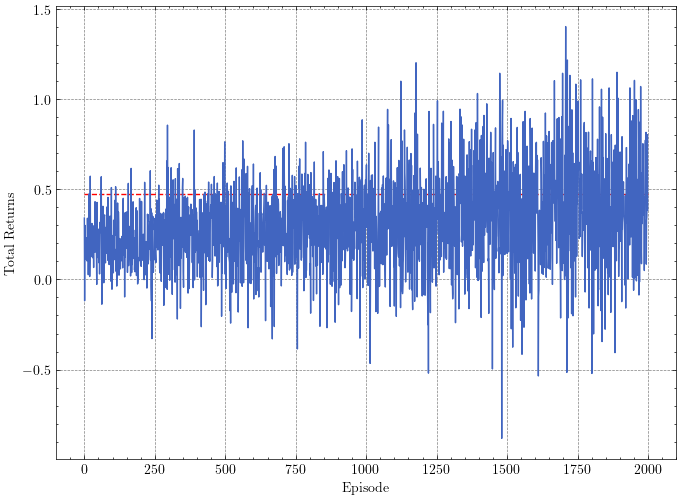

In [8]:
env = GenerativeMarketEnv(
    μ, 
    Σ
)


policy = DirichletPolicy(
    8,  α=2, α_end=8e-4, start_ep=9999, 
        α_decay_steps=9999, γ=0.6,
    grad_adpt_mode='natural_gradient', returns_adpt_mode=None,
    parameterisation='softplus'
)
harness = Harness(env, policy)
eps = 2000
harness.train(num_episodes=eps)
harness.plot_smooth_rewards(eps, window=1)

In [9]:
labels = ['AAPL', 'AMZN', 'FB', 'GM', 'GOOG', 'JPM', 'BP', 'TSLA']

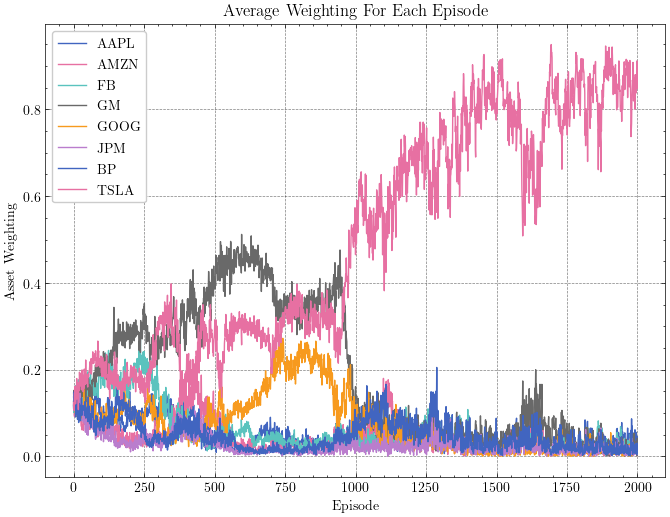

In [10]:
harness.plot_weights_vs_ep(labels=labels)

# Differential Sharpe Ratio (DSR)

Object function: Sharpe Ratio
Typical RL task tries to optimize the object function

$$U_T=U(R_1, R_2, ..., R_T)$$

where $R_i$ is the instaneous reward at time $t$. For general $Q$-learning or policy gradient algorithm, the object function is

$$U_T=\sum_{i=1}^{T}\gamma^{i-1}\cdot R_i$$

which is a discounted cunmulated sum of all one-step reward. However, such object function does not take market risk into consideration. The simplest benchmark to measure risk and return is the Sharpe ratio, i.e.

$$U_T=\frac{E(R)}{\text{std}(R)}$$

with $E(R)=(1/T)\sum_{i=1}^{T}R_i$ and std is the standard deviation. However, such object function is not additive, which prohibits us to use the old wisdom such as $Q$-learning and vanilla policy gradient methods.

J.Moody propose the idea of DSR, which can turn $U$ above into an additive sum of single step reward.

First, for given step n, the Sharpe ratio $U_n$ can be estimated by

$$U_n=\frac{A_n}{K_n(B_n-A_n^2)^{1/2}}$$

with

$$A_n=\frac{1}{n}\sum_{i=1}^n R_i~~\text{and}~~B_n=\frac{1}{n}\sum_{i=1}^n R_i^2 ~~ K_n=(\frac{n}{n-1})^{1/2}$$

both $A$ and $B$ satisfy the following recurrent relation

$$A_n=\frac{1}{n}R_n+\frac{n-1}{n}A_{n-1}~~\text{and}~~B_n=\frac{1}{n}R_n^2+\frac{n-1}{n}B_{n-1}$$

Now we can extend such formulism to an exponential moving average Sharpe ratio on time scale $\eta^{-1}$ by making use of the EMA of $A$ and $B$,

$$S_t=\frac{A_t}{K_{\eta}(B_t-A_t^2)^{1/2}}$$

with

$$A_t=\eta R_t+(1-\eta)A_{t-1}=A_{t-1}+\eta\Delta A_t$$

$$B_t=\eta R_t^2 +(1-\eta)B_{t-1}=B_{t-1}+\eta\Delta B_t$$

$$K_{\eta}=(\frac{1-\eta/2}{1-\eta})^{1/2}$$

initialized with $A(0)=B(0)=0$. Now we can write for small $\eta$ that

$$U_t=U_{t-1}+\eta \frac{\partial U_t}{\partial \eta}+O(\eta^2)$$

where we define the DSR as

$$D_t=\frac{\partial U_t}{\partial \eta}=\frac{B_{t-1}\Delta A_t-A_{t-1}\Delta B_t/2}{(B_{t-1}-A_{t-1}^2)^{3/2}}$$

Now if we expand the whole $U_T$ to first order of $\eta$, we have

$$U_T\simeq \eta \sum_{i=1}^T D_i + O(\eta^2)$$

Now the original object function of Sharpe ratio becomes totally additive to first order. One step reward is now replaced by $D_t$. It means that we can use $D_t$ as reward and leave all others of RL framework unchanged.

Numerical simulation of DSR
Here use S&P500 daily close price to illustrate the idea of DSR. We note that the initial condition $A(0)=B(0)=0$ is singular for the definition of DSR. Thus we in practice, we shall use the former 200 days to calculate a base SR as the initial value of $A$ and $B$ and then begin to calculate $D_t$ in the following iteration.



In [11]:
amzn_df = pd.read_csv('../../data/yahoo/16-03-21/AMZN.csv')
amzn_returns = np.array(amzn_df['Close'].pct_change()[1:])

In [33]:
At = 0
Atm1 = 0

Bt = 0
Btm1 = 0

Dt = 0

η = 0.05

Dt = []

for amzn_r in amzn_returns:
    At = Atm1 + η*(amzn_r - Atm1)
    Bt = Btm1 + η*(amzn_r**2 - Btm1)
    
    num = Btm1*(amzn_r - Atm1) - Atm1*(amzn_r**2 - Btm1)/2
    denom = (Btm1 - Atm1**2)**(3/2)
    
    Dt.append(num/denom)
    
    Atm1 = At
    Btm1 = Bt
    

    

<ipython-input-33-0307b2ffaf15>:20: RuntimeWarning: invalid value encountered in double_scalars
  Dt.append(num/denom)


In [34]:
Dt

[nan,
 0.6483121206140214,
 1.3876466164773267,
 -1.73776483531387,
 1.449516137457885,
 0.8992157370668311,
 -2.6391058068217457,
 1.5489357380841995,
 -2.207812521664542,
 1.359688626549804,
 -0.5565296131179659,
 -1.4345066795355386,
 0.19500168809729312,
 -0.4455466494510817,
 1.9271477924685514,
 0.19925520683706735,
 0.5869688160845502,
 -0.17062258780031642,
 1.8029908441444689,
 1.4181995774988643,
 0.2170443784516385,
 1.1754167536546838,
 -1.1334222046004467,
 0.08966357258625267,
 -2.0042408096322237,
 0.42436836914357523,
 0.42936765566685076,
 -0.024464578389086084,
 -1.0518418822236395,
 -1.7333967561572545,
 0.8535755582362773,
 1.3100002004587754,
 -5.828972533079593,
 0.35091963969364065,
 -0.06740726311642499,
 0.4091883381012662,
 0.1499311357000172,
 0.08293462107274886,
 0.35540195640698247,
 -1.0904222265051857,
 0.09172816679500496,
 0.25812091196056786,
 0.2572496232182562,
 0.18110878335068611,
 0.29518791608618555,
 0.7090531438938797,
 -1.241723200104299,
 -0